# CSS Lab: Network Structure
This lab demonstrates how to use common tools to analyze the structure of several networks. Topics covered include visualization, centrality measures, shortest paths, and affiliation networks. At the end of the lab, you will be able to visualze and perform an analysis of your own social network.

## Contents

1. [Setup](#Setup)
2. [Build and visualize a network](#Build-and-visualize-a-network)
    1. [Load the network](#Load-the-network)
    2. [Visualize the network](#Visualize-the-network)
3. [Centrality measures](#Centrality-measures)
    1. [Find centrality](#Find-centrality)
    2. [Interpret centrality](#Interpret-centrality)
    3. [Compare centrality measures](#Compare-centrality-measures)
4. [Paths](#Paths)
    1. [Find path lengths](#Find-path-lengths)
    2. [Bridges and weak ties](#Bridges-and-weak-ties)
    3. [Find minimum cut](#Find-minimum-cut)
5. [Affiliation networks](#Affiliation-networks)
    1. [Weighted edges](#Weighted-edges)
6. [Your social network](#Your-social-network)
    1. [Visualize your social network](#Visualize-your-social-network)
    2. [Social network communities](#Social-network-communities)
    3. [Social network centrality](#Social-network-centrality)
    4. [Find connected component](#Find-connected-component)
    5. [Social network path lengths](#Social-network-path-lengths)
    6. [Find bridges](#Find-bridges)
7. [References](#References)
    


## Setup
We import several libraries, including `networkx` for network algorithms, `pandas` for data processing, and `visJS2jupyter` for visualization.

In [10]:
%pylab inline
import itertools
import json
import math
import urllib.request
import networkx as nx
import networkx as networkx
import networkx.algorithms as nxalg
import networkx.algorithms.community as nxcom
import networkx.readwrite as nxrw
import pandas as pd
import visJS2jupyter.visJS_module as vjs

Populating the interactive namespace from numpy and matplotlib


## Build and visualize a network

This section loads network data from a file and explores its basic properties. 

In [11]:
# Helper functions

def load_hamilton_affiliation():
    B = nxrw.adjlist.read_adjlist("external/hamilton.csv", delimiter="; ", comments="%")
    return B

def load_hamilton(threshold=None):
    # Load the song-character affiliation network
    B = load_hamilton_affiliation()
    # Get list of songs from the file
    songs = set()
    with open("external/hamilton.csv") as f:
        f.readline()
        for row in f:
            songs.add(row.split("; ")[0])
    # Deduce list of charactes
    characters = set(B.nodes()) - songs
    # Project the affiliation network onto the set of characters
    G = nxalg.bipartite.projection.weighted_projected_graph(B, characters)
    # Threshold
    if threshold is not None:
        for s, t, data in list(G.edges(data=True)):
            if data["weight"] < threshold:
                G.remove_edge(s,t)
    return G

def get_colors():
    phi = (1 + math.sqrt(5)) / 2
    color = []
    for i in range(1, 20):
        theta = phi * i * math.pi * 2
        x = 128 + math.floor(64*math.sin(theta))
        y = 128 + math.floor(64*math.cos(theta))
        color.append((x, x, y))
    return color

def visualize_visjs(
        G, communities=None, colors=None, default_color="192,192,192",
        node_size_field="node_size", layout="spring", scale=500, pos=None,
        groups=None, weight=None, labels=dict(), title=""):
    # Get list of nodes and edges
    nodes = list(G.nodes())
    edges = list(G.edges())
    # Change node shapes for bipartite graph
    if groups is None:
        node_shapes = dict()
        node_sizes = dict()
        node_colors = dict()
    else:
        node_shapes = dict((n, "square") for n in groups)
        node_sizes = dict((n, 15) for n in groups)
        node_colors = dict((n, "192,128,0") for n in groups)
    # Per-node properties
    nodes_dict = dict((n, {
        "id": labels.get(n, n),
        "node_size": node_sizes.get(n, 5),
        "node_shape": node_shapes.get(n, "dot")
        }) for n in nodes)
    # Generate a layout for the nodes
    edge_smooth_enabled = False
    edge_width = 4
    edge_arrow_scale = 2
    if communities is not None and pos is None:
        # Generate initial positions based on community
        phi = 3.14 / len(nodes)
        community_node = []
        # Create list of nodes and their communities
        for i, com in enumerate(sorted(communities, key=lambda x: len(x), reverse=True)):
            for node in com:
                community_node.append((i, node))
        # Sort by community and
        community_node = sorted(community_node)
        # Generate initial position by placing communities around a circle
        pos = dict((d[1], (math.cos(i*phi), math.sin(i*phi))) for i, d in enumerate(community_node))
    else:
        pos = None
    if layout == "circle":
        pos = nx.circular_layout(G, scale=scale)
    elif layout == "spring":
        pos = nx.spring_layout(G, k=3/math.sqrt(len(nodes)), scale=scale, pos=pos)
    else:
        edge_smooth_enabled = True
    # Assign position
    for n in nodes:
        nodes_dict[n]["x"] = pos[n][0]
        nodes_dict[n]["y"] = pos[n][1]
    # Calculate bounds for scaling
    x_min = min(pos.values(), key=lambda x: x[0])[0]
    x_max = max(pos.values(), key=lambda x: x[0])[0]
    y_min = min(pos.values(), key=lambda x: x[1])[1]
    y_max = max(pos.values(), key=lambda x: x[1])[1]
    x_range = x_max - x_min
    y_range = y_max - y_min
    max_range = max(x_range, y_range)
    # If we have communities, assign color based on community
    if colors is None:
        colors = ["{},{},{}".format(*c) for c in get_colors()]
    if communities is not None:
        for i, com in enumerate(sorted(communities, key=lambda x: len(x), reverse=True)):
            for node in com:
                try:
                    nodes_dict[node]["color"] = "rgba({},1)".format(colors[i])
                    nodes_dict[node]["color_index"] = i
                except IndexError:
                    nodes_dict[node]["color"] = "rgba({},1)".format(default_color)
    # Update color for bipartite nodes
    for node, node_attr in nodes_dict.items():
        if node in node_colors:
            node_attr["color"] = "rgba({},1)".format(node_colors[node])
    # Map node labels to contiguous ids
    node_map = dict(zip(nodes,range(len(nodes))))
    # Determine edge colors
    edge_colors_idx = {}
    for source, target in edges:
        source_color = nodes_dict[source].get("color_index", None)
        target_color = nodes_dict[target].get("color_index", None)
        if source_color == target_color and source_color is not None:
            edge_colors_idx[(source, target)] = source_color
    edge_colors = dict(
        (e,colors[c])
        for e, c in edge_colors_idx.items() if c < len(colors))
    # Per-edge properties, use contiguous ids to identify nodes
    edge_scale = math.ceil(max_range / 200)
    edges_dict = []
    for source, target, data in G.edges(data=True):
        edge = {
            "source": node_map[source],
            "target": node_map[target],
            "title":'test',
            "color": "rgba({},0.3)".format(edge_colors.get((source,target), default_color)),
            "edge_width_field": "value",
            "value": data.get("value", 1) * edge_scale
        }
        edges_dict.append(edge)
    # Convert nodes dict to node list
    nodes_list = [nodes_dict[n] for n in nodes]
    # Check for directed graph
    if G.__class__ == nx.classes.digraph.DiGraph:
        directed = True
    else:
        directed = False
    # Call visjs
    return vjs.visjs_network(
        nodes_list, edges_dict,
        node_size_field="node_size",
        node_size_multiplier=10.0,
        edge_width_field="value",
        edge_width=edge_width,
        edge_arrow_to=directed,
        edge_arrow_to_scale_factor=edge_arrow_scale,
        edge_smooth_enabled=edge_smooth_enabled,
        edge_smooth_type="curvedCW",
        graph_id=hash(title))


### Load the network

The next cell loads data from a file using the `networkx` library,
and displays a list of nodes in the network.
This example uses characters from the play _Hamilton_.

In [12]:
G = load_hamilton()
sorted(G.nodes())

['A. Burr',
 'A. Hamilton',
 'A. Schuyler',
 'C. Lee',
 'E. Schuyler',
 'G. Eaker',
 'G. Washington',
 'George III',
 'H. Mulligan',
 'J. Laurens',
 'J. Madison',
 'J. Reynolds',
 'Lafayette',
 'M. Reynolds',
 'P. Hamilton',
 'P. Schuyler',
 'S. Seabury',
 'T. Jefferson']

Now that you know the labels of the nodes, you can see which nodes are connected by an edge.
In this case, two nodes are connected by an edge if the corresponding characters have parts in the same song.
The next cell chooses a single node and prints a list of all the other nodes it's connected to.
These nodes are called its neighbors.

In [13]:
sorted(G.neighbors('E. Schuyler'))

['A. Burr',
 'A. Hamilton',
 'A. Schuyler',
 'C. Lee',
 'G. Washington',
 'H. Mulligan',
 'J. Laurens',
 'Lafayette',
 'P. Hamilton',
 'P. Schuyler']

### Visualize the network
In these visualizations, each circle represents a node.
Edges between two nodes are represented by drawing a line between them.

There are many ways to draw a network.
One simple way is to space all the nodes evenly around a circle.

In [14]:
visualize_visjs(G, layout="circle", title="Circular Layout Example")

Another common way to visualize a network is using a "force-directed" layout.
In a force-directed layout, nodes push away from each other, but edges act like springs pulling them back together.
As a result, nodes with many neighbors in common are pulled closer to each other.

In [ ]:
visualize_visjs(G, scale=1000, title="Force-Directed")

What do the people in the center of the network have in common? What about the people around the edge?

What are some benefits and drawbacks of the circular layout versus the force-directed layout?

## Centrality measures

One benefit of representing data as a network is that the patterns of connections between nodes can reveal useful information.
Many standard techniques for investigating the structure of networks have been developed.

One of the simplest questions to ask is: which nodes are most important?
But what does "important" mean exactly?
There are several common ways to measure importance, or _centrality_, of nodes in a nework.
This section examines several of the most popular.

While the _Hamilton_ network in the previous section is simple enough to be illustrative,
a historical data set better demonstrates how centrality measures can be applied to real-world networks.
This section uses historical data on affilations between organizers of the American Revolution,
taken from [Using Metadata to Find Paul Revere](https://kieranhealy.org/blog/archives/2013/06/09/using-metadata-to-find-paul-revere/).

In [ ]:
# Helper functions

def load_revere_affiliation(
        url="https://raw.githubusercontent.com/kjhealy/revere/master/data/PaulRevereAppD.csv"):
    data = urllib.request.urlopen(url)
    df = pd.read_csv(data).set_index("Unnamed: 0")
    people = list(df.index)
    groups = list(df.columns)
    #
    B = nx.Graph()
    for column in df.columns:
        for row in df[df[column] == 1].index:
            B.add_edge(column, row)
    return people, groups, B

def load_revere(
        url="https://raw.githubusercontent.com/kjhealy/revere/master/data/PaulRevereAppD.csv",
        threshold=None, dual=False):
    # Load the affiliation network
    people, groups, B = load_revere_affiliation(url)
    # Project the affiliation network onto the set of people
    if dual:
        G = nxalg.bipartite.projection.weighted_projected_graph(B, groups)
    else:
        G = nxalg.bipartite.projection.weighted_projected_graph(B, people)
    # Threshold
    if threshold is not None:
        for s, t, data in list(G.edges(data=True)):
            if data["weight"] < threshold:
                G.remove_edge(s,t)
    # Copy "weight" data to "value" needed by visjs
    w = nx.get_edge_attributes(G, "weight")
    nx.set_edge_attributes(G, w, "value")
    return G

# Standardize a vector to 0 mean and unit variance
def scale(v):
    return (v - v.mean()) / v.std()

# Return a data frame sorted by a node's centrality relative the mean of its centralities
def rel_centrality(df, measure, labels=dict()):
    name = 'rel_{}'.format(measure)
    return pd.DataFrame({
        name: scale(df[measure]) / df['mean_centrality'],
        "label": [labels.get(x, x) for x in df.index]
    })

The next cell begins by loading the data into a `networkx` graph. As is, an analysis of the data will reveal Paul Revere to be highly central by all measures [Healey2013] so to make the example more interesting, let's ask this: if Paul Revere had been on vacation, who might have notified the Massachusetts Provincial Congress of the impending attack in his place? To do so, we remove Paul Revere from the network. 

In [ ]:
G = load_revere()
people, groups, B = load_revere_affiliation()
G.remove_node('Revere.Paul')

Before continuing, the next cell visualizes the network. Take a minute to examine the network and consider the following questions:
* Who might act as a bridge between different parts of the network?
* Who are the most well-connected?
* Who might play a role similar to Paul Revere?

In [ ]:
visualize_visjs(G, scale=1500, title="American Revolution")

### Find centrality
Now let's move on to examine the centralities. The next cell uses `networkx` to calculate node centralities and then stores them in a data frame. For each node we also calculate a mean centrality value.

In [ ]:
df = pd.DataFrame({"id": G.nodes(), "label": G.nodes()}).set_index("id")
df['degree'] = pd.Series(nx.degree_centrality(G))
df['betweenness'] = pd.Series(nx.betweenness_centrality(G))
df['closeness'] = pd.Series(nx.closeness_centrality(G))
df['eigenvector'] = pd.Series(nx.eigenvector_centrality(G))

In [ ]:
# Calculate mean of all centrality measures
df['mean_centrality'] = (
    scale(df['degree'])
    + scale(df['betweenness'])
    + scale(df['closeness'])
    + scale(df['eigenvector'])) / 4.0

#### Degree

One very simple way to find important nodes is to count how many neighbors they have.
This measure is called the degree centrality.
This number is typically divided by the total number of other nodes in the network, so a value
of 0.82 means that a node is connected to 82% of the other nodes.
The next cell shows the nodes with the highest degree centralities.

Note that some of the people have the same degree. In fact, if two people have exactly the same set of neighbors,
all of their centrality scores will be the same.

In [ ]:
df.sort_values('degree', ascending=False).head(5)

Instead of searching for the highest degree centrality nodes, we can find nodes that have an unusually high degree centrality compared to its other centralities.

* How do the results below compare to those above?
* Why might someone have a high centrality of one type and a low centrality of another type?

In [ ]:
rel_centrality(df, 'degree').sort_values('rel_degree', ascending=False).head()

#### Betweenness

Rather than highly-connected nodes, you might want to find nodes that connect different parts of the network.
These types of nodes are sometimes called bridges, or brokers.
The betweenness centrality is based on finding the shortest path between nodes.
The nodes on that path play the role of bridges, connecting the endpoints.
So the betweenness is the fraction of all shortest paths in the network that pass through a given node.

In [ ]:
df.sort_values('betweenness', ascending=False).head(5)

In [ ]:
rel_centrality(df, 'betweenness').sort_values('rel_betweenness', ascending=False).head()

#### Closeness

A nodes might also be considered important if it is close to many other nodes.
In other words, if the paths connecting it to other nodes are all very short.
This measure is called closeness centrality.

In [ ]:
df.sort_values('closeness', ascending=False).head(5)

In [ ]:
rel_centrality(df, 'closeness').sort_values('rel_closeness', ascending=False).head()

### Eigenvector

The last centrality measure covered in this section measures not just how well-connected a node is, but how well-connected its neighbors are as well.
This measure is the eigenvector centrality.
The PageRank algorithm used by Google to find high quality websites is an extension of this algorithm.

In [ ]:
df.sort_values('eigenvector', ascending=False).head(5)

In [ ]:
rel_centrality(df, 'eigenvector').sort_values('rel_eigenvector', ascending=False).head(5)

### Interpret centrality

Looking over the above centrality results, consider the questions below. It may be helpful to see the list of organizations a person belonged to, which can be done in the next cell.

* Did any of the measures show the same people as being most central?
* Members of the Tea Party (e.g. `Collier.Gershom`) have a high degree centrality, but low betweenness centrality. What does that tell you about the Tea Party as compared to other groups?
* What would a group with _high_ betweenness and _low_ degree centrality look like?
* Of the important people you identified from the visualization, were any in the lists of high-centrality individuals? If so, which types of centrality.


In [ ]:
list(nx.neighbors(B, "Collier.Gershom"))

### Compare centrality measures

The following plot shows how different centrality measures are related to each other (in this network).
Each graph compares two centrality measures corresponding to its row and column.
In each graph, each point represents a single node in the network.

Points are drawn with transparency so overlapping points are darker.
If a group of people have the same centralities,
possibly because they have the same set of neighbors,
they appear as a single dark spot.

In [ ]:
# Store column names in array to keep order consistent
measures = ["degree", "betweenness", "eigenvector", "closeness"]
plt.figure(figsize=(7,6))
# Loop through rows and columns
# Even though we have 4 measures, we only need 3x3 to compare all
for row in range(3):
    for col in range(3):
        # Each row column pair only needs to be plotted once
        if row >= col:
            # The longest row should correspond to the measure that
            # does not appear on a column.
            x, y = df[measures[row]], df[measures[(col-1) % 4]]
            plt.subplot(3,3,1 + row*3 + col)
            plt.plot(x, y, '.', alpha=0.3, markersize=10)
            plt.xlim([0, x.max()]); plt.ylim([0, y.max()])
        if row == 2:
            plt.xlabel(measures[(col - 1) % 4])
        if col == 0:
            plt.ylabel(measures[row])
plt.tight_layout()

## Community structure

What if you didn't know the groups people belonged to and wanted to find them from the network? This is the problem of community detection. There are many ways to find communities. The following cells find and visualize communities using a method that maximizes _modularity_ [CNM2004]. Networks with high modularity have a high number of edges between nodes in the same community and a low number of edges across communities. One benefit of this method is that it determines the best number of communities. In the visualization below, different communities are shown in different colors.

In [ ]:
communities = list(nxcom.greedy_modularity_communities(G))

In [ ]:
visualize_visjs(G, communities=communities, scale=1500, title="Community Detection Example")

### Interpreting communites
When interpreting the communities, it will be helpful to see lists of the organizations each individual belonged to. The next cell will show that list for each individual. To start interpreting the communities, consider the following questions:
* Do the communities make sense?
* Can you connect particular communities to actual organizations?
* Why would two organizations belong to the same community when two others don't?

In [ ]:
list(nx.neighbors(B, "Church.Benjamin"))

## Paths

It is also informative to consider the shortest paths of a network.
For a pair of nodes, the shortest path is the path connecting them in the fewest number of hops.
The example below uses a network of characters from the novel _A Storm of Swords_ [BS2016],
with edges representing characters mentioned at the same time.

In [15]:
# Helper functions

def load_asoiaf():
    G = nx.Graph()
    with open("external/stormofswords.csv") as f:
        f.readline()
        for row in f:
            source, target, weight = row.split(",")
            G.add_edge(source, target, weight=int(weight), capacity=1)
    return G

def path_histogram(G, log=False):
    # Find shortest path length for each pair
    path_lengths = list(itertools.chain(*[
            [length for length in targets.values() if length > 0]
        for source, targets in list(nxalg.shortest_path_length(G))]))
    # Draw histogram with integer bins
    bins = [0.5 + x for x in range(max(path_lengths)+1)]
    counts, centers, patches = plt.hist(
        path_lengths, bins=bins, rwidth=0.8)
    if log:
        plt.yscale('log', nonposy='clip')
        ymax = np.power(10, np.ceil(np.log10(max(counts))))
    else:
        place = np.power(10, np.floor(np.log10(max(counts))))
        ymax = np.ceil(max(counts) / place) * place
    # Plot average shortest path length
    mean_path = nxalg.average_shortest_path_length(G)
    plt.plot([mean_path, mean_path], [1, ymax], label="mean")
    plt.ylim([1, ymax])
    plt.xlabel("Path length")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()

def longest_geodesic(G):
    paths = nxalg.shortest_path(G)
    longest = 0
    longest_path = []
    for source, source_paths in paths.items():
        for target, path in source_paths.items():
            if len(path) > longest:
                longest = len(path)
                longest_path = path
    return path

First, load and visualize the network.

In [16]:
G = load_asoiaf()
visualize_visjs(G, title="asoiaf", scale=1000)

### Find path lengths
Next, plot a histogram of the path lengths as well as the mean path length. The diameter of a network is the length of the longest shortest path.
* How do the mean shortest path, mode shortest path, and the longest path compare?
* Do you think these values would stay the same if the network was larger? Why or why not?

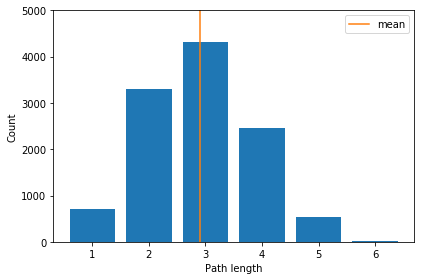

In [17]:
path_histogram(G)

The cell above found the distribution of paths lengths, but it is also informative to look at individual paths. The following cell prints the shortest path between the two most distant nodes in the network. You might expect the endpoints to be very different in some way, perhaps separated geographically, or socially. Similarly the nodes in the middle are ones that connect distant parts of the network, and are likely to play an important role in the network.

In [18]:
print(longest_geodesic(G))

['Walton', 'Jaime', 'Arya', 'Jon', 'Craster', 'Karl']


### Bridges and weak ties
We can also find edges which act as bridges between different parts of the network. An edge is a bridge if removing it disconnects two parts of a network.
More generally, a local bridge connects two nodes that would otherwise be far apart.
If removing an edge causes its endpoints to become distance _n_ apart,
it is called a local bridge of degree n.

Bridges are often _weak ties_ [Granovetter1977] because individuals with a strong connection are likely to have common friends.

In [19]:
# Helper functions

def find_bridges(G, labels=None):
    bridges = []
    for v, w in G.edges():
        H = G.copy()
        H.remove_edge(v, w)
        try:
            d = nx.shortest_path_length(H, source=v, target=w)
            if d <= 2:
                continue
        except nx.NetworkXNoPath:
            d = float("Inf")
        if labels is None:
            bridges.append((d, v, w))
        else:
            bridges.append((d, labels[v], labels[w]))
    bridges = sorted(bridges, key=lambda x: x[0], reverse=True)
    for b in bridges:
        if b[0] == float("Inf"):
            print("Global bridge:\t{} <-> {}".format(b[1], b[2]))
        else:
            print("Local bridge, degree {}:\t{} <-> {}".format(*b))

In [20]:
find_bridges(G)

Global bridge:	Jaime <-> Qyburn
Global bridge:	Jaime <-> Walton
Global bridge:	Tyrion <-> Doran
Global bridge:	Amory <-> Oberyn
Global bridge:	Jon <-> Orell
Global bridge:	Belwas <-> Illyrio
Global bridge:	Robb <-> Ramsay
Global bridge:	Craster <-> Karl
Global bridge:	Daenerys <-> Aegon
Global bridge:	Daenerys <-> Kraznys
Global bridge:	Daenerys <-> Rakharo
Global bridge:	Daenerys <-> Worm
Global bridge:	Davos <-> Cressen
Global bridge:	Davos <-> Salladhor
Global bridge:	Davos <-> Shireen
Global bridge:	Kevan <-> Lancel
Local bridge, degree 3:	Robert <-> Jon Arryn
Local bridge, degree 3:	Tyrion <-> Janos
Local bridge, degree 3:	Tyrion <-> Viserys
Local bridge, degree 3:	Tywin <-> Val
Local bridge, degree 3:	Lysa <-> Jon Arryn
Local bridge, degree 3:	Elia <-> Rhaegar


### Find minimum cut
Sometimes you might want to know where a network is most fragile.
The minimum cut finds the fewest number of links that need to be removed to break a network into two pieces.
In the beginning of the _A Song of Ice and Fire_ series, exiled princess Daenerys Targaryen and her brother Viserys seek to reclaim the throne from reigning king Robert Baratheon.
You can use the minimum cut to find the links that separate characters connected to the Targaryens from those more closely connected to the Baratheons.

First we find the minimum cut: the number of edges separating the two factions.

In [ ]:
mincut, cuts = nxalg.minimum_cut(G, 'Daenerys', 'Robert')
mincut

Now we can visualize the min cut. Who in the "Robert" cluster is closest to members of the "Daenerys" cluster? Why might Daenerys want to identify those people?

In [ ]:
visualize_visjs(G, communities=cuts, scale=1500, title="Mincut")

## Affiliation networks
Sometimes it is useful to consider two different types of nodes.
Often, this is the case when the two types of nodes are groups and members of those groups,
with the edges representing membership.
Such networks are called affiliation networks.
The American Revolution data from before was created from an affiliation network.
The cell below visualizes the full affiliation network.
Notice that person nodes are only connected to group nodes and vice versa.

In [ ]:
peopele, groups, B = load_revere_affiliation()
visualize_visjs(B, scale=1500, groups=groups, title="American Revolution Affiliation")

Previously, this affilation network was used to create a network connecting people to people.
But we can just as easily create a network connecting groups to groups (if they have a common member) [Breiger1974]. 

In [ ]:
G = load_revere(dual=True)
visualize_visjs(G, title="American Revolution Groups", groups=G.nodes())

### Weighted edges
In the above example, two groups have an edge between them if they have a common member.
But some groups might have only one member in common, while others have many.
These differences can be represented by adding a _weight_ do the edge.
In this case, weights represent how many members two groups have in common,
but weights can represent anything: distance, similarity, etc.

In [ ]:
visualize_visjs(G, title="American Revolution Weighted", groups=G.nodes(), weight="weight")

## Your social network
Now you can do these analyses on your own social network! Specifically, you can download a list of all of your friends and whether they are friends with each other.
This network is called your "ego network."

If you use Facebook, you can use the LostCircles plugin for Chrome to download your social network.
1. Open the following link in Chrome to install LostCircles:
https://chrome.google.com/webstore/detail/lost-circles-facebook-gra/ehpmfdlcppenimpibdifodjgfafkjhjl?hl=en
2. Click the LostCircles icon on the Chrome toolbar and select "Start Loading."
3. Wait until the menu shows "100%" next to "Start Loading."
4. Click the LostCircles icon and then "Download..." followed by "JSON (no pics)". Save the result as `external/LostCircles/egonet.json`.
5. Continue to the next cell

In [3]:
# Helper functions

def load_lost_circles_json(in_file, name=False):
    with open(in_file) as f:
        raw = json.load(f)
    id_to_name = dict((i, datum["name"]) for i, datum in enumerate(raw['nodes']))
    if name:
        edges = [(id_to_name[datum["source"]], id_to_name[datum["target"]], {"capacity":1}) for datum in raw['links']]
    else:
        edges = [(datum["source"], datum["target"], {"capacity":1}) for datum in raw['links']]
    G = nx.Graph()
    G.add_edges_from(edges)
    return G, id_to_name, edges

### Visualize your social network
Let's start by visualizing your ego network.
* Does it look like there are distinct groups? If so, can you explain why those groups exist?
* Is everyone connected? Or are there disconnected components of the network?

In [4]:
G, id_to_name, edges = load_lost_circles_json("external/LostCircles/egonet.json")
visualize_visjs(G, title="Ego Net", scale=6000, labels=id_to_name)

### Social network communities
Try finding communities within your social network. Do the communities correspond to the groups you identified above?

In [ ]:
communities = nxalg.community.greedy_modularity_communities(G)
visualize_visjs(G, communities=communities, title="Ego Net Communities", scale=6000, labels=id_to_name)

### Social network centrality
Now you can repeat the centrality analysis for members of your own ego network.

In [ ]:
# Calculate centrality measures
df = pd.DataFrame({"id": G.nodes(), "label": [id_to_name[x] for x in G.nodes()]}).set_index("id")
df['degree'] = pd.Series(nx.degree_centrality(G))
df['betweenness'] = pd.Series(nx.betweenness_centrality(G))
df['closeness'] = pd.Series(nx.closeness_centrality(G))
df['eigenvector'] = pd.Series(nx.eigenvector_centrality(G))
# Calculate mean of all centrality measures
df['mean_centrality'] = (
    scale(df['degree'])
    + scale(df['betweenness'])
    + scale(df['closeness'])
    + scale(df['eigenvector'])) / 4.0

#### Degree
These are the most highly connected members of your network. Do they have anything in common?

In [ ]:
df.sort_values('degree', ascending=False).head(5)

In [ ]:
rel_centrality(df, 'degree', labels=id_to_name).sort_values('rel_degree', ascending=False).head(5)

#### Betweenness
These are the individuals who connect different parts of your network. Can you think of reasons these particular individuals might play that role?

In [ ]:
df.sort_values('betweenness', ascending=False).head(5)

In [ ]:
rel_centrality(df, 'betweenness', labels=id_to_name).sort_values('rel_betweenness', ascending=False).head(5)

#### Closeness
These individuals are, on average, closest to everyone you know. Do the results make sense?

In [ ]:
df.sort_values('closeness', ascending=False).head(5)

In [ ]:
rel_centrality(df, 'closeness', labels=id_to_name).sort_values('rel_closeness', ascending=False).head(5)

#### Eigenvector
These individuals are most connected to highly connected individuals. How do they compare to those identified by other methods? Can you explain why these individuals would have high centrality?

In [ ]:
df.sort_values('eigenvector', ascending=False).head(5)

In [ ]:
rel_centrality(df, 'eigenvector', labels=id_to_name).sort_values('rel_eigenvector', ascending=False).head(5)

### Find giant component
Before moving on to examine path length, it is important to consider whether the network is connected. Were there any groups of nodes with no edges going to the rest of the network? If so, some pairs of nodes aren't connected by a path. To get around this, we can examine only the largest connected component, called the _giant component_.

In [7]:
# Helper function
def giant_component(G):
    giant_component = sorted(nxalg.connected_components(G), reverse=True, key=len)[0]
    for v in set(G.nodes()) - giant_component:
        G.remove_node(v)
    return G

In [8]:
G = giant_component(G)

### Social network path lengths
Now let's look at the histogram of paths in your social network. How does it compare to the _A Song of Ice and Fire_ network above? Are most paths longer, shorter, or the same? Are any paths much longer?

In [ ]:
path_histogram(G)

Now consider the path between the most distant nodes. Why might the nodes on the ends be so far separated? Why are the nodes in the middle good at connecting them?

In [ ]:
print([id_to_name[i] for i in longest_geodesic(G)])

### Find bridges
Next, consider the bridges in your social network. Do they correspond to weak ties as hypothesized in [Granovetter1977]? Weak ties can be useful for searching a social network because they connect different communities. For example, if you were looking for a job, who would you ask? Do they appear in any bridges?

In [9]:
# Takes about 10 minutes
find_bridges(G, labels=id_to_name)

Global bridge:	Cha-Ling O'Connell <-> Dan Briggs
Global bridge:	Amy Hailes <-> Helen Hailes
Global bridge:	Gennifer Valeria Gates <-> Julie Koslowsky
Global bridge:	Greg Mayer <-> Michael Fagan
Global bridge:	Matt Oehrlein <-> Chris Murray
Global bridge:	Shannon Refvik <-> Allison Latham
Global bridge:	George Tait <-> El Zot Dio
Global bridge:	Lena Feil <-> Destyni McKinney
Global bridge:	Edward W Platt <-> Tom Platt
Global bridge:	Becky Krug <-> Johnson Ev
Global bridge:	Nathan Doe <-> Merce Badia
Global bridge:	Charles Davey <-> Chrissy Desrochers
Global bridge:	Samantha Daisy Letvin <-> Niki Erna
Global bridge:	Samantha Daisy Letvin <-> Lindsey Behrend
Global bridge:	Hannah Davis <-> Erin Kennedy
Global bridge:	Naomi Seyfer <-> Kate Buckner
Global bridge:	Keara Scannell <-> Oliver Stocker
Global bridge:	Ray Poirier <-> Clint Massey
Global bridge:	Mary Winkler <-> Phyllis Hoard
Global bridge:	Andi Keeley <-> Melodi Jane Lacy
Global bridge:	Talia Selitsky <-> Jill Dimond
Global bridge

## Possible extensions

## References

[Healey2013] Healy, K. 2013. "Using Metadata to Find Paul Revere." https://kieranhealy.org/blog/archives/2013/06/09/using-metadata-to-find-paul-revere/

[CNM2004] Clauset, A., Newman, M. E., & Moore, C. (2004). Finding community structure in very large networks. Physical review E, 70(6).

[RLWGBF2017] Rosenthal, S. B., Len, J., Webster, M., Gary, A., Birmingham, A., & Fisch, K. M. (2017). Interactive network visualization in Jupyter notebooks: visJS2jupyter. Bioinformatics.

[BS2016] A. Beveridge and J. Shan, "Network of Thrones," Math Horizons Magazine , Vol. 23, No. 4 (2016), pp. 18-22

[Breiger1974] Breiger, R. L. (1974). The duality of persons and groups. Social forces, 53(2), 181-190.

[Granovetter1977] Granovetter, M. S. (1977). The strength of weak ties. In Social networks (pp. 347-367).